## 注意力汇聚: Nadaraya-Watson核回归

In [1]:
import torch
import torch.nn as nn
import d2l.torch as d2l

生成数据集

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
def f(x):
    return 2 * torch.sin(x) + x ** 0.8
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

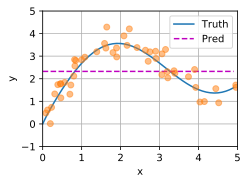

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

非参数注意力汇聚

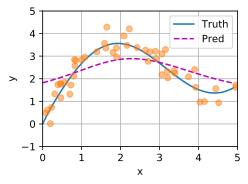

In [4]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim = 1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

注意力权重

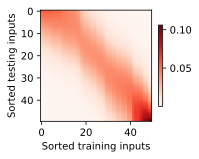

In [5]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

带参数注意力汇聚假定两个张量的形状分别是$(n, a, b)$和$(n, b, c)$, 它们的批量矩阵乘法输出的形状为$(n, a, c)$

In [6]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [7]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

带参数的注意力汇聚

In [8]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
    
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

将训练数据集转换为键和值

In [9]:
X_title = x_train.repeat((n_train, 1))
Y_title = y_train.repeat((n_train, 1))
keys = X_title[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_title[(1-torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)

训练带参数的注意力汇聚模型

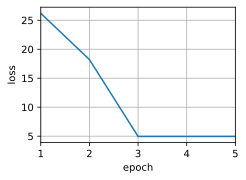

In [10]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum())}:.6f')
    animator.add(epoch+1, float(l.sum()))

预测结果绘制

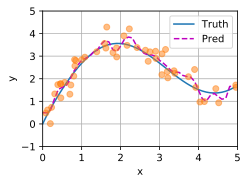

In [11]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

曲线在注意力权重较大的区域变得更不平滑

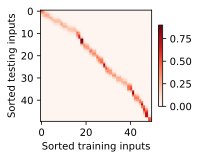

In [12]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel="Sorted training inputs", ylabel="Sorted testing inputs")

## Attention机制

<img src="../images/scaled-dot-product-attention.png" width="50%">


> - 图中`Decoder`的隐藏状态向量`query` $q_t$ 与`Encoder`的隐藏状态向量序列`key` $K=[k_1, k_2, k_3, k_4]$ 每个向量做点积，每个 `key`向量对应一个分数。
- 然后`sofmax`转换为权重分布，权重值越大可以认为越“关注”该处向量的信息。
- 每个位置的 $v$ 与该处的权重相乘，然后求和得到 $q_t$ 对 $K$ 做注意力的输出向量。

## Pytorch实现

In [13]:
import torch, math, torch.nn.functional as F


def attention(query, key, value, mask=None, dropout=None):
    """
    query : batch, target_len, feats
    key   : batch, seq_len,    feats
    value : batch, seq_len,    val_feats
    
    return: batch, target_len, val_feats
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

`query`与`key`去做点积，能够得到`seq_len`个点积之后的结果。再做个`mask`和`softmax`之后，我们就可以得到`attention`，此时的`attention`的长度是$target\_len \times seq\_len$, 再与编码器的value输出纬度$seq\_len \times val\_feats$做矩阵乘法之后，就可以得到解码器`decoder`的输出：

In [14]:
def test_attention():
    query = torch.randn(3, 5, 4)  # batch, target_len, feats
    key = torch.randn(3, 6, 4)  # batch, seq_len, feats
    value = torch.randn(3, 6, 8)  # batch, seq_len, val_feats
    attn, _ = attention(query, key, value)
    print(attn.shape)
    assert attn.shape == (3, 5, 8)
    print("Test passed")

test_attention()

torch.Size([3, 5, 8])
Test passed


## 位置编码

- 如果模型的输出会随着输入文本数据顺序的变化而变化，那么这个模型就是关于位置敏感的，反之则是位置不敏感的。设模型为函数$y=f(x)$，其中输入为一个词序列$x=\{x_1,x_2...x_n\}$。将$x$任意重排序$\hat{x}=\text{shuffle}(x)$，都有$f(\hat{x})=f(x)$，则模型是关于位置不敏感的。
    - 当使用对位置不敏感(position-insensitive)的模型对文本数据建模的时候，才需要额外使用positional encoding。
   
   
- RNN和textCNN都是关于位置敏感的，使用它们对文本数据建模时，模型结构天然考虑了文本中词与词之间的顺序关系。   
- 以attention为核心的transformer则是位置不敏感的，使用这一类位置不敏感的模型的时候需要额外加入positional encoding引入文本中词与词的顺序关系。